In [1]:
import torch
from torch.utils.data import Dataset,DataLoader
import torchvision
import torchvision.transforms as transforms
 
def get_train_loader(mean, std, batch_size=16, num_workers=2, shuffle=True):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
 
    cifar100_training = torchvision.datasets.CIFAR100(root='./data', train=True, download=True,
                                                      transform=transform_train)
    cifar100_training_loader = DataLoader(
        cifar100_training, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size)
 
    return cifar100_training_loader
 
def get_val_loader(mean, std, batch_size=16, num_workers=2, shuffle=True):
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    cifar100_test = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    cifar100_test_loader = DataLoader(
        cifar100_test, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size)
 
    return cifar100_test_loader

In [1]:
import torchvision
import torch
from torch import nn
import torch.nn.functional as F
import math
import os
import matplotlib.pyplot as plt
import numpy as np


In [11]:
class TimeEmbedding(nn.Module):
    """
    T:时间步数量
    d_model:正余弦embedding长度
    dim:TimeEmbedding 长度
    """
    def __init__(self, T, d_model, dim):
        assert d_model % 2 == 0
        super().__init__()
        emb = torch.arange(0, d_model, step=2) / torch.Tensor([d_model]) * math.log(10000)
        emb = torch.exp(-emb)
        pos = torch.arange(T).float()
        emb = pos[:, None] * emb[None, :]
        assert list(emb.shape) == [T, d_model // 2]
        emb = torch.stack([torch.sin(emb), torch.cos(emb)], dim=-1)
        assert list(emb.shape) == [T, d_model // 2, 2]
        emb = emb.view(T, d_model)

        
        self.timembedding = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(d_model, dim),
            nn.GELU(),
            nn.Linear(dim, dim),
        )
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, t):
        emb = self.timembedding(t)
        return emb

    
    
class DownSample(nn.Module):
    def __init__(self,in_c):
        super().__init__()
        self.main=nn.Conv2d(in_c,in_c,3,2,1)
        self.initialize()
    def initialize(self):
        nn.init.xavier_uniform_(self.main.weight)
        nn.init.zeros_(self.main.bias)
    def forward(self,x,t_emb):
        return self.main(x)
    

class UpSample(nn.Module):
    def __init__(self,in_c):
        super().__init__()
        self.main=nn.Conv2d(in_c,in_c,3,1,1)
        self.initialize()
    def initialize(self):
        nn.init.xavier_uniform_(self.main.weight)
        nn.init.zeros_(self.main.bias)
    def forward(self,x,t_emb):
        _,_,H,W=x.shape
        x=F.interpolate(
            x,scale_factor=2,mode='nearest'
        )
        return self.main(x)

    
class AttnBlock(nn.Module):
    def __init__(self,in_c):
        super().__init__()
        self.group_norm=nn.GroupNorm(32,in_c)
        self.proj_q=nn.Conv2d(in_c,in_c,1,1,0)
        self.proj_k=nn.Conv2d(in_c,in_c,1,1,0)
        self.proj_v=nn.Conv2d(in_c,in_c,1,1,0)
        self.proj_out=nn.Conv2d(in_c,in_c,1,1,0)
        self.initialize()
    def initialize(self):
        for layer in [self.proj_q,self.proj_k,self.proj_v,self.proj_out]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
        nn.init.xavier_uniform_(self.proj_out.weight,gain=1e-5)
    def forward(self,x):
        B,C,H,W=x.shape
        h=self.group_norm(x)
        q=self.proj_q(x)
        k=self.proj_k(x)
        v=self.proj_v(x)
        q=q.permute(0,2,3,1).view(B,H*W,C)
        k=k.view(B,C,H*W)
        w=torch.bmm(q,k)*(int(C)**(-0.5))
        w=F.softmax(w,dim=-1)##(B,H*W,H*W)
        v=v.permute(0,2,3,1).view(B,H*W,C)
        h=torch.bmm(w,v)
        h=h.view(B,H,W,C).permute(0,3,1,2)
        h=self.proj_out(h)
        return x+h


class ResBlock(nn.Module):
    def __init__(self,in_c,out_c,t_dim,dropout,attn=False):
        super().__init__()
        ## block1:调整通道数
        self.block1=nn.Sequential(
            nn.GroupNorm(32,in_c),
            nn.GELU(),
            nn.Conv2d(in_c,out_c,3,1,1)
        )
        
        ## proj_t对加噪步数嵌入加一个线性映射,使得和通道数一样
        self.proj_t=nn.Sequential(
            nn.GELU(),
            nn.Linear(t_dim,out_c)
        )
        
        ## block2:综合步数信息后再进行一个卷积操作
        self.block2=nn.Sequential(
            nn.GroupNorm(32,out_c),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Conv2d(out_c,out_c,3,1,1)
        )
        
        if in_c!=out_c:
            self.short_cut=nn.Conv2d(in_c,out_c,1,1,0)
        else:
            self.short_cut=nn.Identity()
        
        if attn:
            self.attn=AttnBlock(out_c)
        else:
            self.attn=nn.Identity()
        self.initialize()
    def initialize(self):
        for module in self.modules():
            if isinstance(module,(nn.Conv2d,nn.Linear)):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)
        nn.init.xavier_uniform_(self.block2[-1].weight,gain=1e-5)
    def forward(self,x,t_emb):
        h=self.block1(x)
        t_emb=self.proj_t(t_emb)
        h+=t_emb[:,:,None,None]
        h=self.block2(h)
        h=h+self.short_cut(x)
        return self.attn(h)


class UNet(nn.Module):
    def __init__(self,T,c=128,c_mul=[1,2,2,2],attn_list=[1],num_res_block=2,dropout=0.1):
        """
        attn_list:哪些层要使用注意力机制
        """
        super().__init__()
        t_dim=c*4
        self.time_embedding=TimeEmbedding(T,c,t_dim)
        self.head=nn.Conv2d(1,c,3,1,1)##增加通道数
        self.down_blocks=nn.ModuleList()
        c_list=[c]
        now_c=c
        for i,mul in enumerate(c_mul):
            out_c=c*mul
            for _ in range(num_res_block):
                self.down_blocks.append(
                    ResBlock(now_c,out_c,t_dim,dropout,attn=(i in attn_list))
                )
                now_c=out_c
                c_list.append(now_c)
            if i!=len(c_mul)-1:
                self.down_blocks.append(DownSample(now_c))
                c_list.append(now_c)
        
        self.middle_blocks=nn.ModuleList([
            ResBlock(now_c,now_c,t_dim,dropout,attn=True),
            ResBlock(now_c,now_c,t_dim,dropout,attn=False)
        ])
        
        self.up_blocks=nn.ModuleList()
        for i,mul in reversed(list(enumerate(c_mul))):
            out_c=c*mul
            for _ in range(num_res_block+1):
                self.up_blocks.append(
                    ResBlock(c_list.pop()+now_c,out_c,t_dim,dropout,attn=(i in attn_list))
                )
                now_c=out_c
            if i!=0:
                self.up_blocks.append(UpSample(now_c))
                
        self.tail=nn.Sequential(
            nn.GroupNorm(32,now_c),
            nn.GELU(),
            nn.Conv2d(now_c,1,3,1,1)
        )## 更改输出通道数
        self.initialize()
    def initialize(self):
        nn.init.xavier_uniform_(self.head.weight)
        nn.init.zeros_(self.head.bias)
        nn.init.xavier_uniform_(self.tail[-1].weight)
        nn.init.zeros_(self.tail[-1].bias)
    
    def forward(self,x,t):
        t_emb=self.time_embedding(t)
        h=self.head(x)
        h_list=[h]
        for layer in self.down_blocks:
            h=layer(h,t_emb)
            h_list.append(h)
        for layer in self.middle_blocks:
            h=layer(h,t_emb)
        for layer in self.up_blocks:
            if isinstance(layer,ResBlock):
                h=torch.cat([h,h_list.pop()],dim=1)
                #print(h.shape)
            h=layer(h,t_emb)
            
        h=self.tail(h)
        return h

In [8]:
class Model(nn.Module):
    def __init__(self,device,beta_1,beta_T,T):
        super().__init__()
        self.device=device
        self.backbone=UNet(T)
        ## 计算累积乘积
        self.alpha_bars=torch.cumprod(1-torch.linspace(beta_1,beta_T,steps=T),dim=0).to(device)
        self.to(device)
    
    def loss_fn(self,x,idx=None):
        output,epsilon,alpha_bar=self.forward(x,idx=idx,get_target=True)
        loss=torch.mean(torch.square(output-epsilon))
        return loss

    def forward(self,x,idx=None,get_target=False):
        """
        如果idx==None，则为真实数据
        
        """
        if idx==None:
            idx=torch.randint(0,len(self.alpha_bars),size=(x.size(0),)).to(self.device)
            used_alpha_bars=self.alpha_bars[idx][:,None,None,None]
            epslion=torch.randn_like(x)
            x_tilde=epslion*(torch.sqrt(1-used_alpha_bars))+torch.sqrt(used_alpha_bars)*x
        else:
            idx=torch.Tensor([idx for _ in range(x.size(0))]).to(self.device).long()
            x_tilde=x
        output=self.backbone(x_tilde,idx)
        return (output,epslion,used_alpha_bars) if get_target else output

In [95]:
class DiffusionProcess():
    def __init__(self,beta_1,beta_T,T,diffusion_fn,device,shape):
        """
        diffusion_fn  : trained diffusion network
        shape         : data shape
        """
        self.betas=torch.linspace(beta_1,beta_T,steps=T)
        self.alphas=1-self.betas
        self.alpha_bars=torch.cumprod(self.alphas,dim=0).to(device)
        self.prev_alpha_bars=torch.cat([torch.Tensor([1]).to(device),self.alpha_bars[:-1]])
        self.shape=shape
        self.device=device
        self.diffusion_fn=diffusion_fn
    def one_diffusion_step(self,x):
        for idx in reversed(range(len(self.alphas))):
            noise=torch.zeros_like(x) if idx==0 else torch.randn_like(x)
            sqrt_tilde_beta=torch.sqrt(self.betas[idx]*(1-self.prev_alpha_bars[idx])/(1-self.alpha_bars[idx]))
            espilon=self.diffusion_fn(x,idx)
            if(torch.any(torch.isnan(espilon))):
                print('epsilon isnan!')
            mu_theta_xt=(torch.sqrt(1/self.alphas[idx]))*(x-(1-self.alphas[idx])/torch.sqrt(1-self.alpha_bars[idx])*espilon)
            x=mu_theta_xt+sqrt_tilde_beta*noise
            yield x
            
    @torch.no_grad()
    def sampling(self,sampling_num,only_final=False):
        sample=torch.randn([sampling_num,*self.shape]).to(self.device)
        sampling_list=[]
        final=None
        for sample in self.one_diffusion_step(sample):
            final=sample
            if not only_final:
                sampling_list.append(sample)
        return final if only_final else sampling_list
        
            

In [58]:
def imshow(sample, sampling_number = 64):
    plt.figure(figsize=(6, 6))
    #clear_output()
    row_number = int(math.sqrt(sampling_number))
    col_number = int(math.sqrt(sampling_number))
    sample = sample[:sampling_number].detach().cpu().numpy()
    shape = sample.shape
    show_sample = np.zeros([row_number * shape[2], col_number * shape[3] ]).astype(np.float32)
    for row in range(row_number):
        for col in range(col_number):
            sample_ = sample[row + col * row_number][0]
            show_sample[ row * shape[2] : (row+1) * shape[2], col * shape[3] : (col+1) * shape[3] ] = (sample_ - sample_.min()) / (sample_.max() - sample_.min()) * 255
            
    show_sample = show_sample.astype(np.uint8)
    plt.axis(False)
    plt.imshow(show_sample, cmap = 'gray')
    plt.show()

In [107]:
beta_1=1e-4
beta_T=0.02
T=500
shape=(1,32,32)
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model=Model(device,beta_1,beta_T,T)
process=DiffusionProcess(beta_1,beta_T,T,model,device,shape)
optim=torch.optim.Adam(model.parameters(),lr=1e-4)

In [116]:
sampling_number = 16
only_final = True
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((shape[-2], shape[-1])),
    torchvision.transforms.ToTensor()
])

dataset = torchvision.datasets.MNIST(root = './MNIST', train=True, download=True, transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 64, drop_last = True, num_workers = 0)


Epoch 2/5:   7%|▋         | 62/937 [00:15<03:39,  3.99batch/s, loss=0.0138]

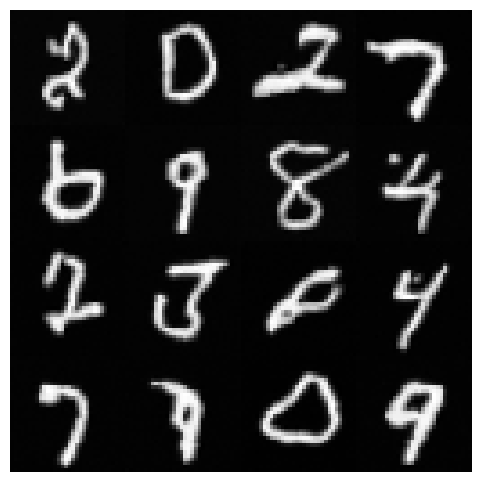

Epoch 3/5:  13%|█▎        | 126/937 [00:42<03:23,  3.99batch/s, loss=0.0150]

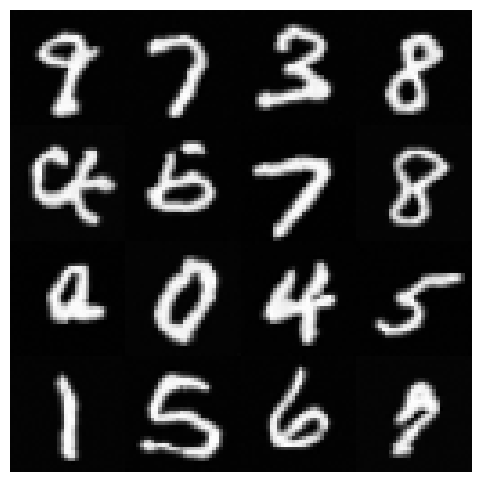

Epoch 4/5:  20%|██        | 188/937 [00:47<03:07,  3.99batch/s, loss=0.0164]

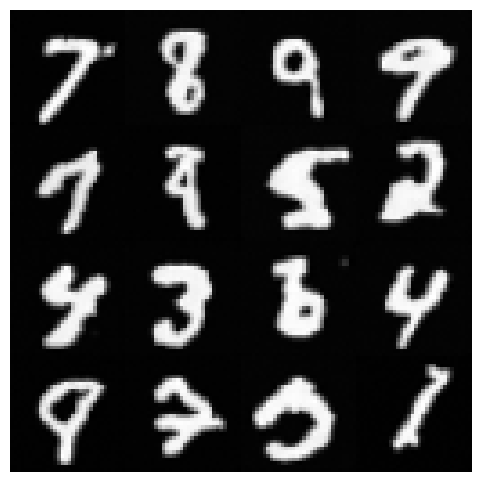

Epoch 5/5:  27%|██▋       | 252/937 [01:15<02:52,  3.98batch/s, loss=0.0226]

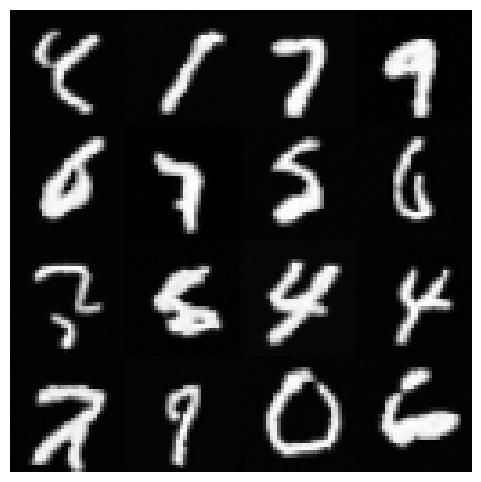

Epoch 5/5: 100%|██████████| 937/937 [04:08<00:00,  3.77batch/s, loss=0.0150]


In [117]:
from IPython.display import clear_output
from tqdm import tqdm
loss_list=[]
epochs=5
for epoch in range(epochs):
    with tqdm(total=len(dataloader), desc=f'Epoch {epoch + 1}/{epochs}', unit='batch',mininterval=3) as pbar:
        for i,(imgs,labels) in enumerate(dataloader):
            imgs=imgs.to(device)
            loss = model.loss_fn(imgs)

            optim.zero_grad()
            loss.backward()
            optim.step()

            #print(
            #    "[Epoch %d/%d] [Batch %d/%d] [loss: %f]"
            #    % (epoch, epochs, i, len(dataloader), loss.item())
            #)
            loss_list.append(loss.item())

            batch_done=epoch*len(dataloader)+i
            pbar.set_postfix({'loss': f'{ loss.item():.4f}'})
            pbar.update(1)
            if (batch_done+1)%1000==0:
                process = DiffusionProcess(beta_1, beta_T, T, model, device, shape)
                sample = process.sampling(sampling_number, only_final)
                imshow(sample, sampling_number)
        

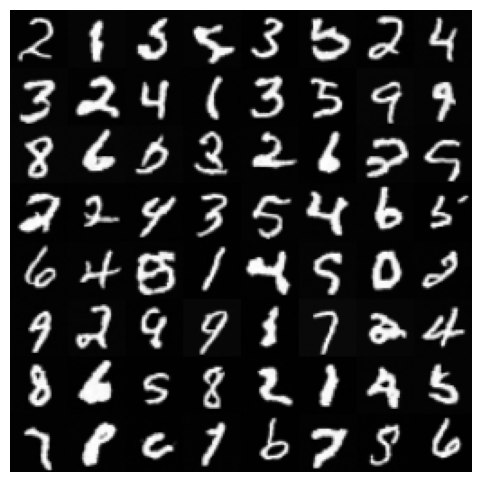

In [118]:
from IPython.display import clear_output
sampling_number = 64
only_final = True
process = DiffusionProcess(beta_1, beta_T, T, model, device, shape)
sample = process.sampling(sampling_number, only_final)
imshow(sample, sampling_number)

In [119]:
def ani_imshow(sample, sampling_number = 64):

    row_number = int(math.sqrt(sampling_number))
    col_number = int(math.sqrt(sampling_number))
    sample = sample[:sampling_number].detach().cpu().numpy()
    shape = sample.shape
    show_sample = np.zeros([row_number * shape[2], col_number * shape[3] ]).astype(np.float32)
    for row in range(row_number):
        for col in range(col_number):
            sample_ = sample[row + col * row_number][0]
            show_sample[ row * shape[2] : (row+1) * shape[2], col * shape[3] : (col+1) * shape[3] ] = (sample_ - sample_.min()) / (sample_.max() - sample_.min()) * 255
            
    show_sample = show_sample.astype(np.uint8)
    
    return show_sample

In [120]:
sampling_number = 16
only_final = False
process = DiffusionProcess(beta_1, beta_T, T, model, device, shape)
sample = process.sampling(sampling_number, only_final)


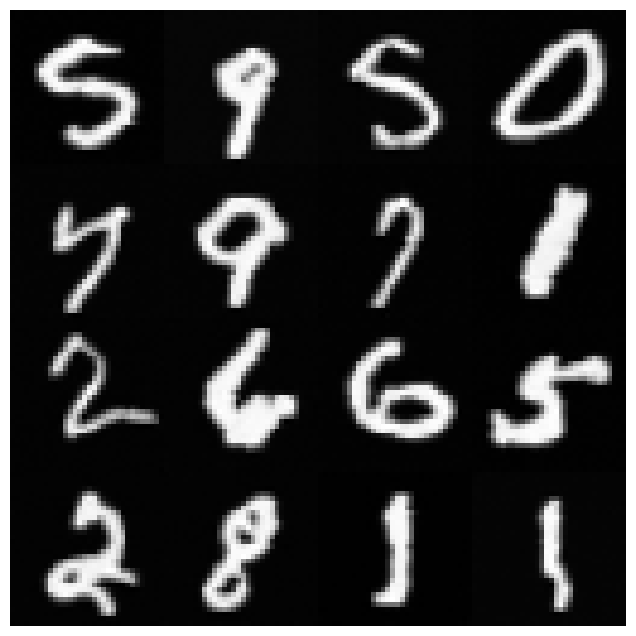

In [121]:
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import clear_output
fig = plt.figure(figsize=(8,8))
plt.axis("off")
show_sample = sample[9::10]
ims = [[plt.imshow(ani_imshow(show_sample[i], sampling_number = sampling_number), animated=True, cmap = 'gray')] for i in range(len(show_sample))]
ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000, blit=True)

writergif = animation.PillowWriter(fps=50) 
ani.save('ddpm_mnist.gif', writer=writergif)

HTML(ani.to_jshtml())

